# Model Output Analysis: Conversation Topic Classifier

Comprehensive analysis of AI classification outputs including topic labels, operational metadata, and cross-field correlations.

## Notebook Structure

1. **Setup & Data Loading** - Import libraries, load dataset, categorical overview
2. **Gold Set Evaluation** - Compare against manual labels
3. **Topic Distribution Analysis** - Classification patterns
4. **Confidence Analysis** - Model certainty patterns
5. **Emotion Analysis** - Customer emotional state patterns
6. **Difficulty Analysis** - Resolution difficulty patterns
7. **Risk & Escalation Analysis** - Risk levels and escalation triggers
8. **Operational Actions Analysis** - Recommended actions patterns
9. **Root Cause Analysis** - Root cause code patterns
10. **Cross-Field Correlations** - Relationships between categorical fields
11. **Handler Actionability** - Summary quality analysis
12. **Model Health Dashboard** - Summary metrics

---
## 1. Setup & Data Loading

In [186]:
"""
Import required libraries for data analysis and visualization.
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import ast
from collections import Counter
from itertools import combinations
import warnings

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Chart export settings
EXPORT_CHARTS = False
CHART_DPI = 150

print("Libraries loaded successfully.")

Libraries loaded successfully.


In [187]:
"""
Load the model output dataset.
"""
AI_LABELS_PATH = "data/conversations_ai_classified.csv"
MANUAL_LABELS_PATH = 'data/conversations_ai_classified_gpt5_2_simple.csv'

df = pd.read_csv(AI_LABELS_PATH)

# Parse list columns
def safe_parse_list(val):
    if pd.isna(val):
        return []
    if isinstance(val, list):
        return val
    try:
        return ast.literal_eval(val)
    except:
        return []

df['operational_actions'] = df['operational_actions'].apply(safe_parse_list)
df['escalation_flags'] = df['escalation_flags'].apply(safe_parse_list)

print(f"Loaded {len(df)} conversations")
print(f"\nColumns: {list(df.columns)}")

Loaded 1000 conversations

Columns: ['conversation_id', 'conversation', 'topic', 'confidence', 'rationale', 'handler_summary', 'emotion', 'difficulty', 'operational_actions', 'risk_level', 'escalation_required', 'escalation_flags', 'root_cause_code', 'root_cause_detail']


In [188]:
"""
Overview of all categorical columns in the dataset.
"""
categorical_cols = ['topic', 'confidence', 'emotion', 'difficulty', 'risk_level', 
                    'escalation_required', 'root_cause_code']

print("="*70)
print("CATEGORICAL COLUMNS OVERVIEW")
print("="*70)

for col in categorical_cols:
    print(f"\n{col.upper()}:")
    print(f"  Unique values: {df[col].nunique()}")
    print(f"  Values: {df[col].unique().tolist()[:10]}")
    
# List columns
print(f"\nOPERATIONAL_ACTIONS (list column):")
all_actions = [a for actions in df['operational_actions'] for a in actions]
print(f"  Unique actions: {len(set(all_actions))}")
print(f"  Total occurrences: {len(all_actions)}")

print(f"\nESCALATION_FLAGS (list column):")
all_flags = [f for flags in df['escalation_flags'] for f in flags]
print(f"  Unique flags: {len(set(all_flags))}")
print(f"  Total occurrences: {len(all_flags)}")

CATEGORICAL COLUMNS OVERVIEW

TOPIC:
  Unique values: 10
  Values: ['Account Access & Customer Profile', 'Returns, Refunds & Exchanges', 'Orders, Shipping & Delivery', 'Product Information & Availability', 'Technical & Platform Issues', 'Product Defects & Fulfillment Errors', 'Billing, Charges & Price Discrepancies', 'General Enquiries & Multi-Intent', 'Promotions, Discounts & Loyalty', 'Complaints, Escalations & Negative Feedback']

CONFIDENCE:
  Unique values: 3
  Values: ['high', 'medium', 'low']

EMOTION:
  Unique values: 5
  Values: ['calm', 'frustrated', 'confused', 'urgent', 'anxious']

DIFFICULTY:
  Unique values: 2
  Values: ['low', 'medium']

RISK_LEVEL:
  Unique values: 3
  Values: ['none', 'low', 'medium']

ESCALATION_REQUIRED:
  Unique values: 2
  Values: [False, True]

ROOT_CAUSE_CODE:
  Unique values: 16
  Values: ['unknown_or_multi_intent', 'recall_or_safety_return', 'cancel_button_or_ui_bug', 'otp_attempts_exceeded_or_lockout', 'delivery_address_issue', 'account_deacti

---
## 2. Gold Set Evaluation

Compare AI classifications against manually labeled data.

In [189]:
"""
Load and merge gold (manual) labels for evaluation.
"""
try:
    manual_df = pd.read_csv(MANUAL_LABELS_PATH)
    pred_df = df[['conversation_id', 'topic']].rename(columns={'topic': 'label_pred'})
    true_df = manual_df[['conversation_id', 'topic']].rename(columns={'topic': 'label_true'})
    eval_df = true_df.merge(pred_df, on='conversation_id', how='inner').dropna()
    GOLD_SET_AVAILABLE = len(eval_df) > 0
    print(f"Gold set loaded: {len(eval_df)} conversations")
except Exception as e:
    GOLD_SET_AVAILABLE = False
    print(f"No gold set available: {e}")

Gold set loaded: 1000 conversations


In [190]:
"""
Classification report comparing AI vs manual labels.
"""
if GOLD_SET_AVAILABLE:
    print("Classification Report (AI vs Manual Labels):")
    print("="*70)
    print(classification_report(eval_df['label_true'], eval_df['label_pred']))
    accuracy = (eval_df['label_true'] == eval_df['label_pred']).mean() * 100
    print(f"\nOverall Accuracy: {accuracy:.1f}%")
else:
    print("Skipped - no gold set available.")

Classification Report (AI vs Manual Labels):
                                             precision    recall  f1-score   support

          Account Access & Customer Profile       0.90      0.96      0.93       136
     Billing, Charges & Price Discrepancies       0.95      0.84      0.89        68
Complaints, Escalations & Negative Feedback       1.00      0.21      0.35        14
           General Enquiries & Multi-Intent       0.44      0.33      0.38        12
                Orders, Shipping & Delivery       0.96      0.92      0.94       229
       Product Defects & Fulfillment Errors       0.76      0.62      0.69        72
         Product Information & Availability       0.74      0.78      0.76       119
            Promotions, Discounts & Loyalty       0.89      0.85      0.87        48
               Returns, Refunds & Exchanges       0.88      0.98      0.93       280
                Technical & Platform Issues       0.21      0.23      0.22        22

                  

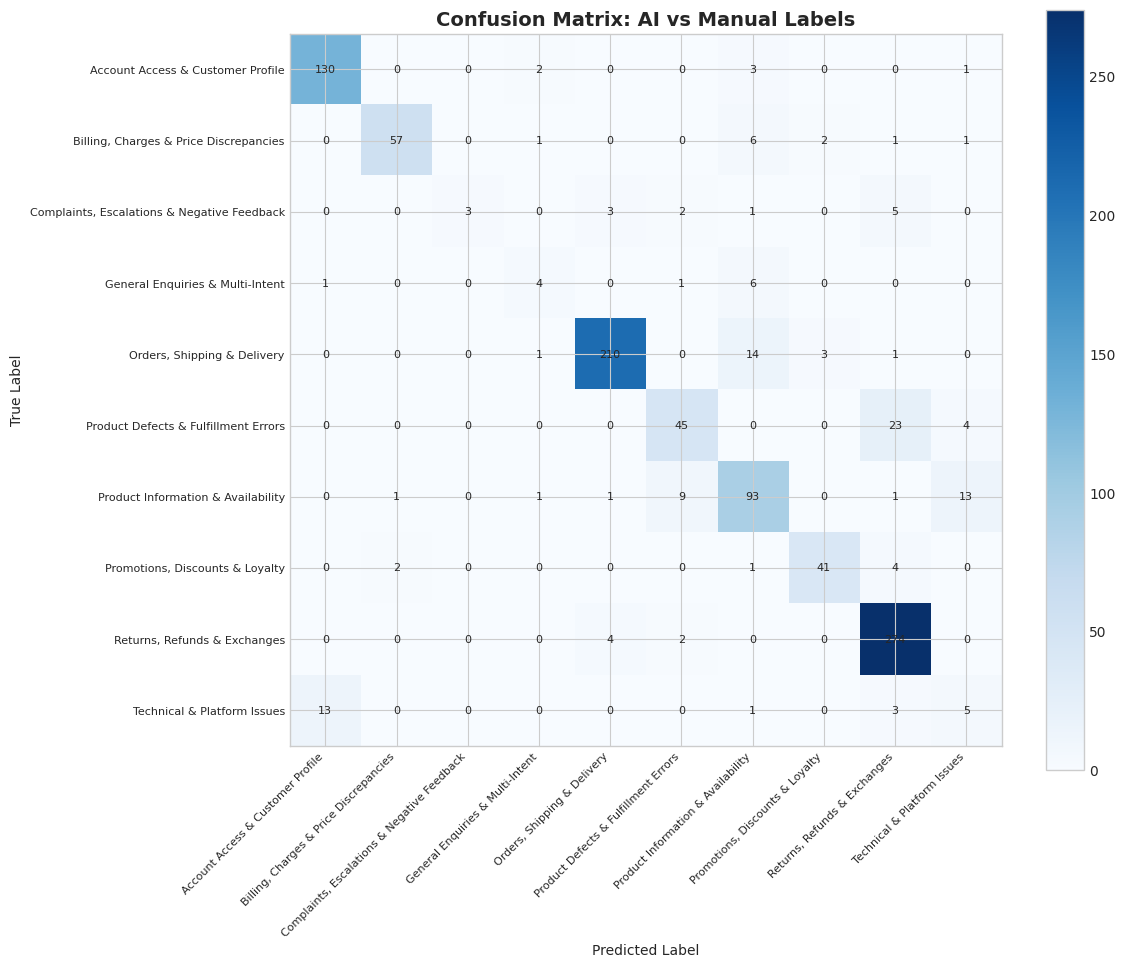

In [191]:
"""
Confusion matrix visualization.
"""
if GOLD_SET_AVAILABLE and len(eval_df) > 0:
    labels = sorted(set(eval_df['label_true'].unique()) | set(eval_df['label_pred'].unique()))
    cm = confusion_matrix(eval_df['label_true'], eval_df['label_pred'], labels=labels)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(cm, cmap='Blues')
    
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(labels, fontsize=8)
    
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=8)
    
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix: AI vs Manual Labels', fontsize=14, fontweight='bold')
    plt.colorbar(im)
    plt.tight_layout()
    plt.show()
else:
    print("Confusion matrix skipped.")

---
## 3. Topic Distribution Analysis

In [192]:
"""
Topic distribution statistics.
"""
topic_counts = df['topic'].value_counts()
topic_pcts = df['topic'].value_counts(normalize=True) * 100

topic_dist = pd.DataFrame({
    'Count': topic_counts,
    'Percentage': topic_pcts.round(1)
})

print(f"Total topics: {len(topic_counts)}")
print(f"\nTopic Distribution:")
topic_dist

Total topics: 10

Topic Distribution:


,Count,Percentage
topic,,
"Returns, Refunds & Exchanges",312,31.2
"Orders, Shipping & Delivery",218,21.8
Account Access & Customer Profile,144,14.4
Product Information & Availability,125,12.5
"Billing, Charges & Price Discrepancies",60,6.0
Product Defects & Fulfillment Errors,59,5.9
"Promotions, Discounts & Loyalty",46,4.6
Technical & Platform Issues,24,2.4
General Enquiries & Multi-Intent,9,0.9


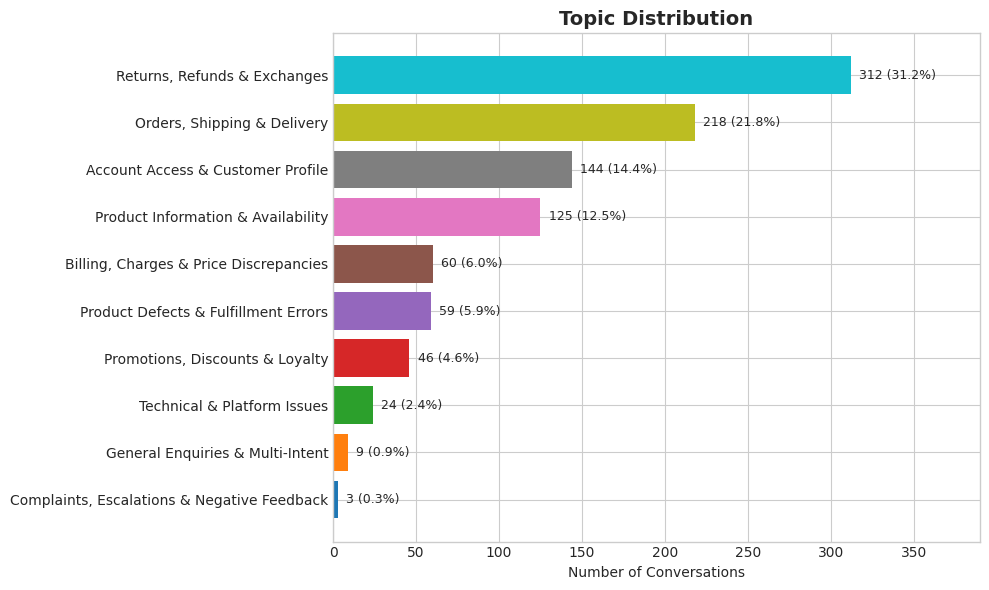

In [193]:
"""
Topic distribution bar chart.
"""
fig, ax = plt.subplots(figsize=(10, 6))

topic_counts_sorted = topic_counts.sort_values(ascending=True)
colors = plt.cm.tab10(np.linspace(0, 1, len(topic_counts)))
bars = ax.barh(topic_counts_sorted.index, topic_counts_sorted.values, color=colors)

for bar, count in zip(bars, topic_counts_sorted.values):
    ax.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, 
            f'{count} ({count/len(df)*100:.1f}%)', va='center', fontsize=9)

ax.set_xlabel('Number of Conversations')
ax.set_title('Topic Distribution', fontsize=14, fontweight='bold')
ax.set_xlim(0, max(topic_counts_sorted.values) * 1.25)
plt.tight_layout()
plt.show()

---
## 4. Confidence Analysis

In [194]:
"""
Overall confidence distribution.
"""
conf_counts = df['confidence'].value_counts().reindex(['high', 'medium', 'low']).fillna(0).astype(int)
conf_pcts = (conf_counts / len(df) * 100).round(1)

print("Overall Confidence Distribution:")
pd.DataFrame({'Count': conf_counts, 'Percentage': conf_pcts})

Overall Confidence Distribution:


,Count,Percentage
confidence,,
high,984,98.4
medium,13,1.3
low,3,0.3


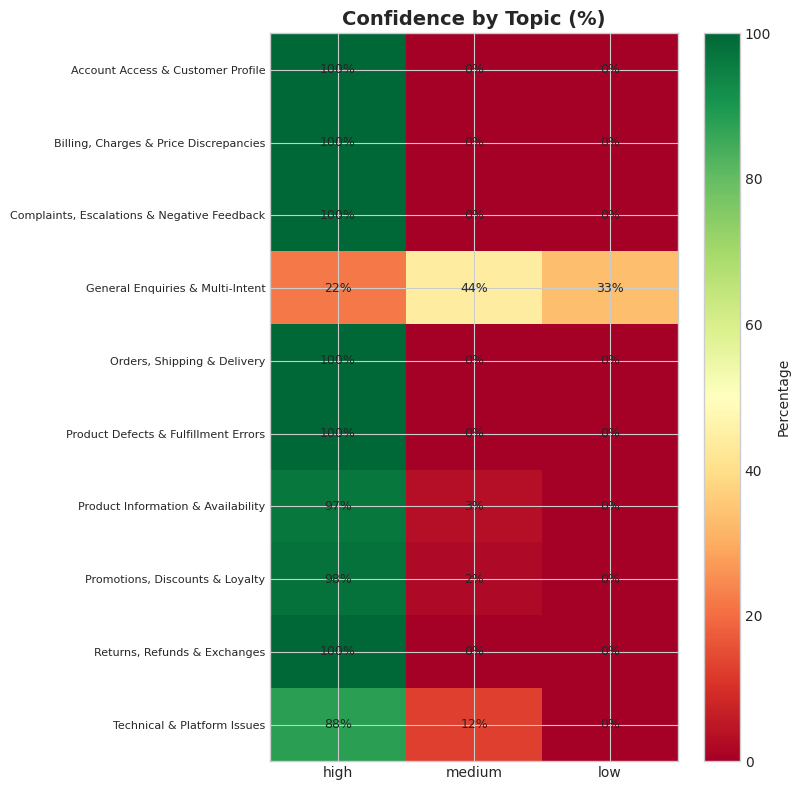

In [195]:
"""
Confidence by topic heatmap.
"""
conf_by_topic = pd.crosstab(df['topic'], df['confidence'], normalize='index') * 100
for col in ['high', 'medium', 'low']:
    if col not in conf_by_topic.columns:
        conf_by_topic[col] = 0
conf_by_topic = conf_by_topic[['high', 'medium', 'low']]

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(conf_by_topic.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)

ax.set_xticks(range(len(conf_by_topic.columns)))
ax.set_yticks(range(len(conf_by_topic.index)))
ax.set_xticklabels(conf_by_topic.columns)
ax.set_yticklabels(conf_by_topic.index, fontsize=8)

for i in range(len(conf_by_topic.index)):
    for j in range(len(conf_by_topic.columns)):
        val = conf_by_topic.iloc[i, j]
        ax.text(j, i, f'{val:.0f}%', ha='center', va='center', fontsize=9)

ax.set_title('Confidence by Topic (%)', fontsize=14, fontweight='bold')
plt.colorbar(im, label='Percentage')
plt.tight_layout()
plt.show()

---
## 5. Emotion Analysis

Analyzing customer emotional states to understand sentiment patterns across topics.

In [196]:
"""
Overall emotion distribution.
"""
emotion_counts = df['emotion'].value_counts()
emotion_pcts = df['emotion'].value_counts(normalize=True) * 100

print("Emotion Distribution:")
emotion_dist = pd.DataFrame({
    'Count': emotion_counts,
    'Percentage': emotion_pcts.round(1)
})
emotion_dist

Emotion Distribution:


,Count,Percentage
emotion,,
calm,632,63.2
frustrated,305,30.5
urgent,40,4.0
anxious,12,1.2
confused,11,1.1


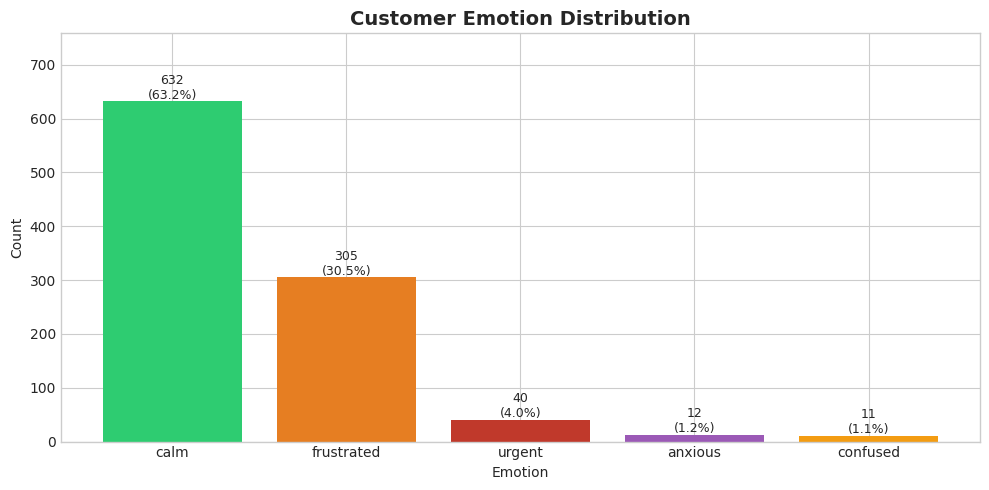

In [197]:
"""
Emotion distribution bar chart with color coding.
"""
emotion_colors = {
    'calm': '#2ecc71',
    'confused': '#f39c12',
    'frustrated': '#e67e22',
    'angry': '#e74c3c',
    'anxious': '#9b59b6',
    'urgent': '#c0392b'
}

fig, ax = plt.subplots(figsize=(10, 5))
emotions = emotion_counts.index.tolist()
colors = [emotion_colors.get(e, '#95a5a6') for e in emotions]

bars = ax.bar(emotions, emotion_counts.values, color=colors)

for bar, count, pct in zip(bars, emotion_counts.values, emotion_pcts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
            f'{count}\n({pct:.1f}%)', ha='center', fontsize=9)

ax.set_xlabel('Emotion')
ax.set_ylabel('Count')
ax.set_title('Customer Emotion Distribution', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(emotion_counts.values) * 1.2)
plt.tight_layout()
plt.show()

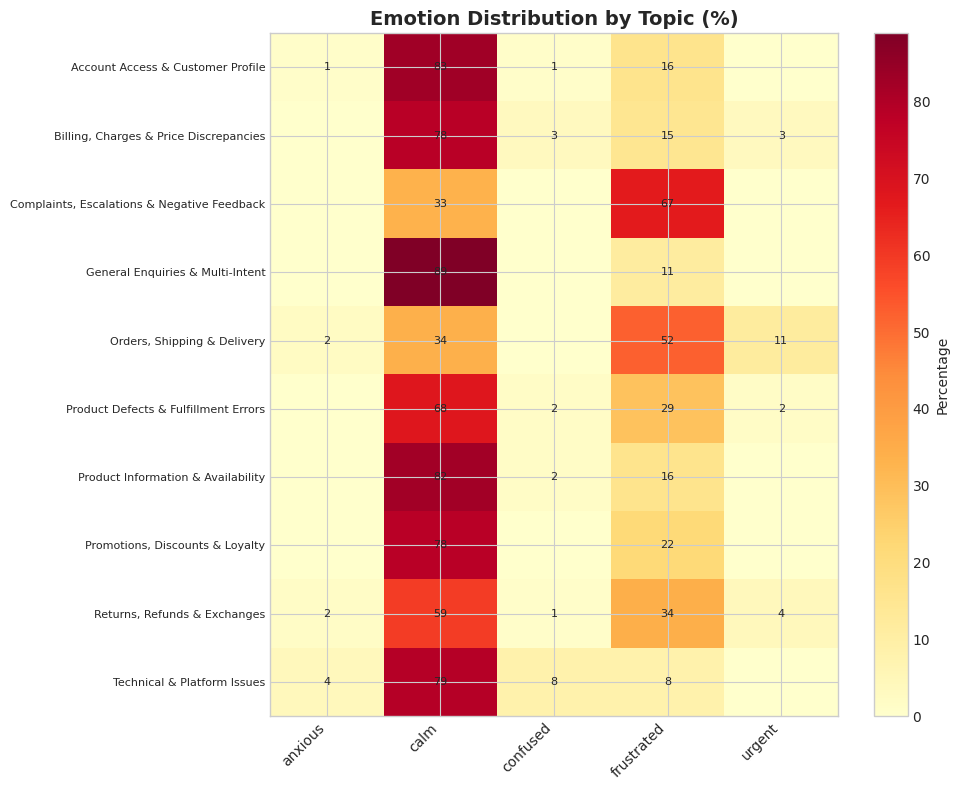


Emotion by Topic (counts):


emotion,anxious,calm,confused,frustrated,urgent
topic,,,,,
Account Access & Customer Profile,1,119,1,23,0
"Billing, Charges & Price Discrepancies",0,47,2,9,2
"Complaints, Escalations & Negative Feedback",0,1,0,2,0
General Enquiries & Multi-Intent,0,8,0,1,0
"Orders, Shipping & Delivery",5,74,0,114,25
Product Defects & Fulfillment Errors,0,40,1,17,1
Product Information & Availability,0,103,2,20,0
"Promotions, Discounts & Loyalty",0,36,0,10,0
"Returns, Refunds & Exchanges",5,185,3,107,12


In [198]:
"""
Emotion by Topic heatmap.
"""
emotion_by_topic = pd.crosstab(df['topic'], df['emotion'], normalize='index') * 100

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(emotion_by_topic.values, cmap='YlOrRd', aspect='auto')

ax.set_xticks(range(len(emotion_by_topic.columns)))
ax.set_yticks(range(len(emotion_by_topic.index)))
ax.set_xticklabels(emotion_by_topic.columns, rotation=45, ha='right')
ax.set_yticklabels(emotion_by_topic.index, fontsize=8)

for i in range(len(emotion_by_topic.index)):
    for j in range(len(emotion_by_topic.columns)):
        val = emotion_by_topic.iloc[i, j]
        if val > 0:
            ax.text(j, i, f'{val:.0f}', ha='center', va='center', fontsize=8)

ax.set_title('Emotion Distribution by Topic (%)', fontsize=14, fontweight='bold')
plt.colorbar(im, label='Percentage')
plt.tight_layout()
plt.show()

print("\nEmotion by Topic (counts):")
pd.crosstab(df['topic'], df['emotion'])

In [199]:
"""
Emotion intensity score by topic.
Scale: calm=0, confused=1, anxious=2, frustrated=3, angry=4, urgent=5
"""
emotion_intensity = {
    'calm': 0, 'confused': 1, 'anxious': 2, 
    'frustrated': 3, 'angry': 4, 'urgent': 5
}

df['emotion_score'] = df['emotion'].map(emotion_intensity)

intensity_by_topic = df.groupby('topic')['emotion_score'].agg(['mean', 'std', 'count'])
intensity_by_topic = intensity_by_topic.sort_values('mean', ascending=False)
intensity_by_topic.columns = ['Avg Intensity', 'Std Dev', 'Count']

print("Emotion Intensity by Topic (0=calm to 5=urgent):")
intensity_by_topic.round(2)

Emotion Intensity by Topic (0=calm to 5=urgent):


,Avg Intensity,Std Dev,Count
topic,,,
"Orders, Shipping & Delivery",2.19,1.70,218
"Complaints, Escalations & Negative Feedback",2.00,1.73,3
"Returns, Refunds & Exchanges",1.26,1.59,312
Product Defects & Fulfillment Errors,0.97,1.46,59
"Promotions, Discounts & Loyalty",0.65,1.25,46
"Billing, Charges & Price Discrepancies",0.65,1.35,60
Account Access & Customer Profile,0.50,1.11,144
Product Information & Availability,0.50,1.10,125
Technical & Platform Issues,0.42,0.93,24


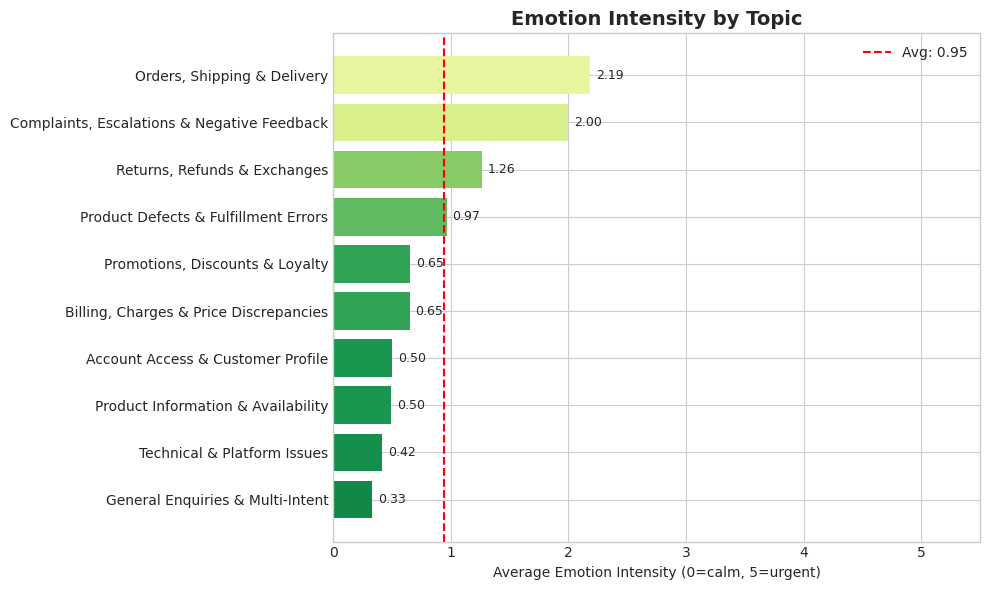

In [200]:
"""
Emotion intensity bar chart.
"""
fig, ax = plt.subplots(figsize=(10, 6))

intensity_sorted = intensity_by_topic['Avg Intensity'].sort_values(ascending=True)
colors = plt.cm.RdYlGn_r(intensity_sorted.values / 5)

bars = ax.barh(intensity_sorted.index, intensity_sorted.values, color=colors)

for bar, val in zip(bars, intensity_sorted.values):
    ax.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, 
            f'{val:.2f}', va='center', fontsize=9)

ax.set_xlabel('Average Emotion Intensity (0=calm, 5=urgent)')
ax.set_title('Emotion Intensity by Topic', fontsize=14, fontweight='bold')
ax.set_xlim(0, 5.5)
ax.axvline(x=intensity_by_topic['Avg Intensity'].mean(), color='red', linestyle='--', 
           label=f'Avg: {intensity_by_topic["Avg Intensity"].mean():.2f}')
ax.legend()
plt.tight_layout()
plt.show()

---
## 6. Difficulty Analysis

Analyzing resolution difficulty across topics and other dimensions.

In [201]:
"""
Overall difficulty distribution.
"""
diff_counts = df['difficulty'].value_counts().reindex(['low', 'medium', 'high']).fillna(0).astype(int)
diff_pcts = (diff_counts / len(df) * 100).round(1)

print("Difficulty Distribution:")
pd.DataFrame({'Count': diff_counts, 'Percentage': diff_pcts})

Difficulty Distribution:


,Count,Percentage
difficulty,,
low,419,41.9
medium,581,58.1
high,0,0.0


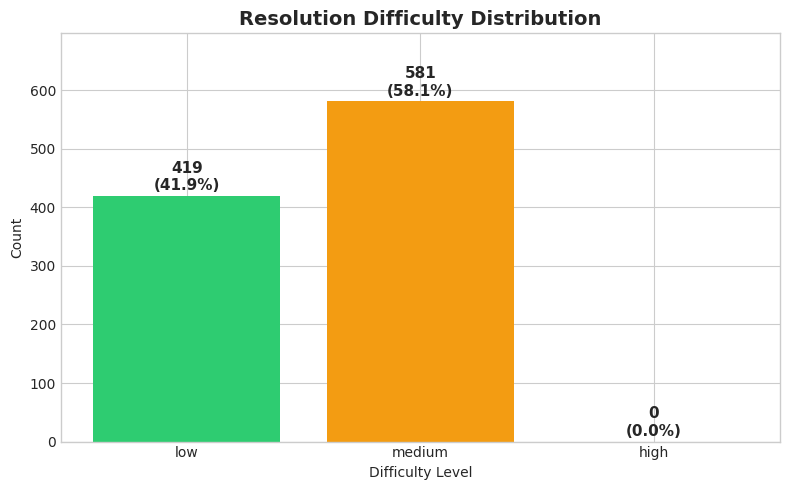

In [202]:
"""
Difficulty distribution bar chart.
"""
diff_colors = {'low': '#2ecc71', 'medium': '#f39c12', 'high': '#e74c3c'}

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(diff_counts.index, diff_counts.values, 
              color=[diff_colors.get(d, 'gray') for d in diff_counts.index])

for bar, count, pct in zip(bars, diff_counts.values, diff_pcts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
            f'{count}\n({pct}%)', ha='center', fontsize=11, fontweight='bold')

ax.set_xlabel('Difficulty Level')
ax.set_ylabel('Count')
ax.set_title('Resolution Difficulty Distribution', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(diff_counts.values) * 1.2)
plt.tight_layout()
plt.show()

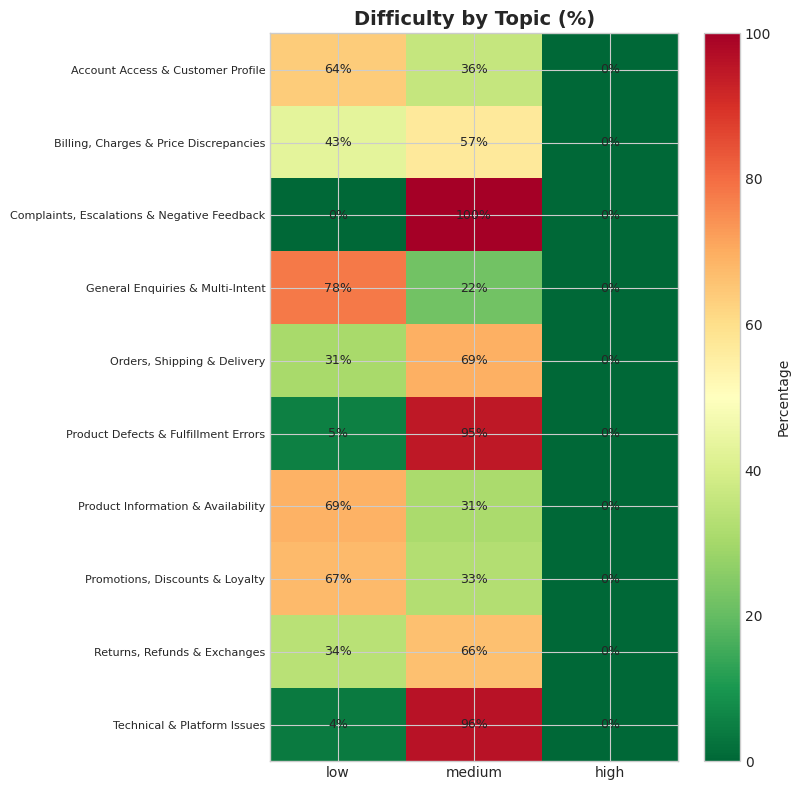


Difficulty by Topic (counts):


difficulty,low,medium
topic,,
Account Access & Customer Profile,92,52
"Billing, Charges & Price Discrepancies",26,34
"Complaints, Escalations & Negative Feedback",0,3
General Enquiries & Multi-Intent,7,2
"Orders, Shipping & Delivery",67,151
Product Defects & Fulfillment Errors,3,56
Product Information & Availability,86,39
"Promotions, Discounts & Loyalty",31,15
"Returns, Refunds & Exchanges",106,206


In [203]:
"""
Difficulty by Topic heatmap.
"""
diff_by_topic = pd.crosstab(df['topic'], df['difficulty'], normalize='index') * 100
for col in ['low', 'medium', 'high']:
    if col not in diff_by_topic.columns:
        diff_by_topic[col] = 0
diff_by_topic = diff_by_topic[['low', 'medium', 'high']]

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(diff_by_topic.values, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=100)

ax.set_xticks(range(len(diff_by_topic.columns)))
ax.set_yticks(range(len(diff_by_topic.index)))
ax.set_xticklabels(diff_by_topic.columns)
ax.set_yticklabels(diff_by_topic.index, fontsize=8)

for i in range(len(diff_by_topic.index)):
    for j in range(len(diff_by_topic.columns)):
        val = diff_by_topic.iloc[i, j]
        ax.text(j, i, f'{val:.0f}%', ha='center', va='center', fontsize=9)

ax.set_title('Difficulty by Topic (%)', fontsize=14, fontweight='bold')
plt.colorbar(im, label='Percentage')
plt.tight_layout()
plt.show()

print("\nDifficulty by Topic (counts):")
pd.crosstab(df['topic'], df['difficulty'])

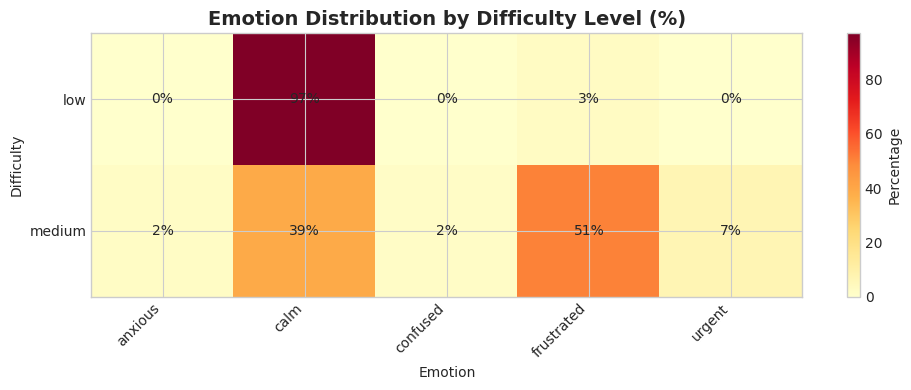


Difficulty by Emotion (counts):


emotion,anxious,calm,confused,frustrated,urgent
difficulty,,,,,
low,0,407,0,11,1
medium,12,225,11,294,39


In [204]:
"""
Difficulty by Emotion heatmap - understanding correlation.
"""
diff_by_emotion = pd.crosstab(df['difficulty'], df['emotion'], normalize='index') * 100

fig, ax = plt.subplots(figsize=(10, 4))
im = ax.imshow(diff_by_emotion.values, cmap='YlOrRd', aspect='auto')

ax.set_xticks(range(len(diff_by_emotion.columns)))
ax.set_yticks(range(len(diff_by_emotion.index)))
ax.set_xticklabels(diff_by_emotion.columns, rotation=45, ha='right')
ax.set_yticklabels(diff_by_emotion.index)

for i in range(len(diff_by_emotion.index)):
    for j in range(len(diff_by_emotion.columns)):
        val = diff_by_emotion.iloc[i, j]
        ax.text(j, i, f'{val:.0f}%', ha='center', va='center', fontsize=10)

ax.set_xlabel('Emotion')
ax.set_ylabel('Difficulty')
ax.set_title('Emotion Distribution by Difficulty Level (%)', fontsize=14, fontweight='bold')
plt.colorbar(im, label='Percentage')
plt.tight_layout()
plt.show()

print("\nDifficulty by Emotion (counts):")
pd.crosstab(df['difficulty'], df['emotion'])

---
## 7. Risk & Escalation Analysis

Analyzing risk levels, escalation requirements, and escalation triggers.

In [205]:
"""
Risk level distribution.
"""
risk_counts = df['risk_level'].value_counts().reindex(['none', 'low', 'medium', 'high']).fillna(0).astype(int)
risk_pcts = (risk_counts / len(df) * 100).round(1)

print("Risk Level Distribution:")
pd.DataFrame({'Count': risk_counts, 'Percentage': risk_pcts})

Risk Level Distribution:


,Count,Percentage
risk_level,,
none,507,50.7
low,326,32.6
medium,167,16.7
high,0,0.0


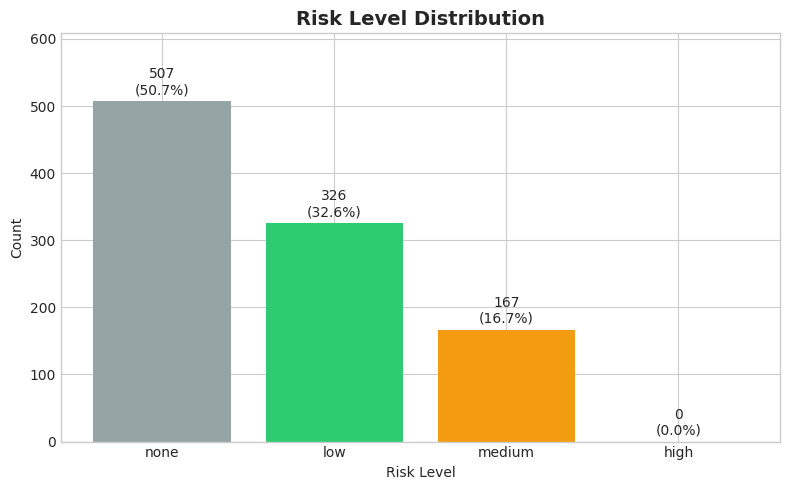

In [206]:
"""
Risk level bar chart.
"""
risk_colors = {'none': '#95a5a6', 'low': '#2ecc71', 'medium': '#f39c12', 'high': '#e74c3c'}

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(risk_counts.index, risk_counts.values, 
              color=[risk_colors.get(r, 'gray') for r in risk_counts.index])

for bar, count, pct in zip(bars, risk_counts.values, risk_pcts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
            f'{count}\n({pct}%)', ha='center', fontsize=10)

ax.set_xlabel('Risk Level')
ax.set_ylabel('Count')
ax.set_title('Risk Level Distribution', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(risk_counts.values) * 1.2)
plt.tight_layout()
plt.show()

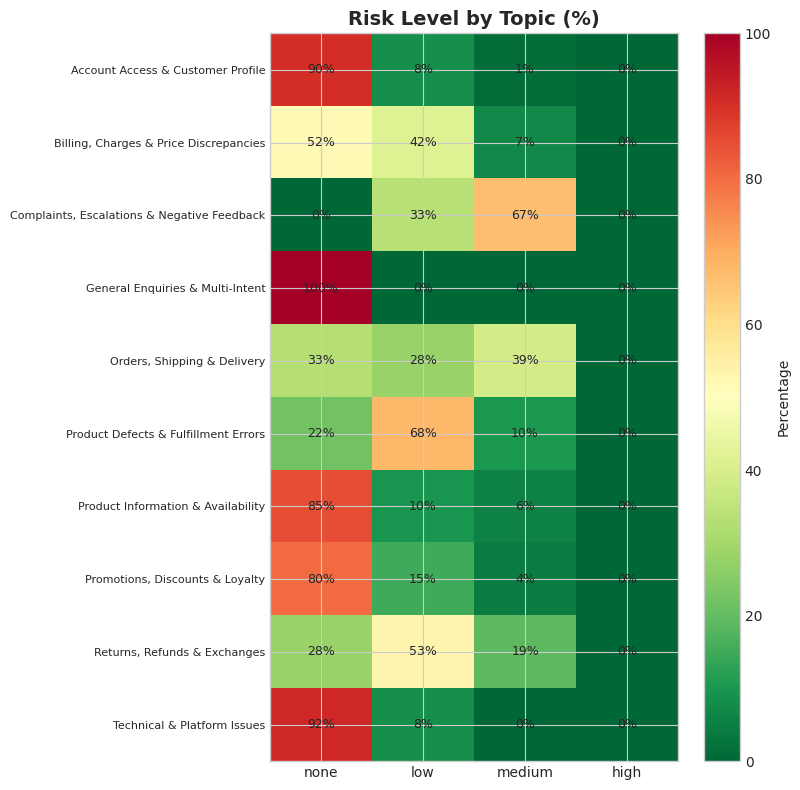

In [207]:
"""
Risk level by topic heatmap.
"""
risk_by_topic = pd.crosstab(df['topic'], df['risk_level'], normalize='index') * 100
for col in ['none', 'low', 'medium', 'high']:
    if col not in risk_by_topic.columns:
        risk_by_topic[col] = 0
risk_by_topic = risk_by_topic[['none', 'low', 'medium', 'high']]

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(risk_by_topic.values, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=100)

ax.set_xticks(range(len(risk_by_topic.columns)))
ax.set_yticks(range(len(risk_by_topic.index)))
ax.set_xticklabels(risk_by_topic.columns)
ax.set_yticklabels(risk_by_topic.index, fontsize=8)

for i in range(len(risk_by_topic.index)):
    for j in range(len(risk_by_topic.columns)):
        val = risk_by_topic.iloc[i, j]
        ax.text(j, i, f'{val:.0f}%', ha='center', va='center', fontsize=9)

ax.set_title('Risk Level by Topic (%)', fontsize=14, fontweight='bold')
plt.colorbar(im, label='Percentage')
plt.tight_layout()
plt.show()

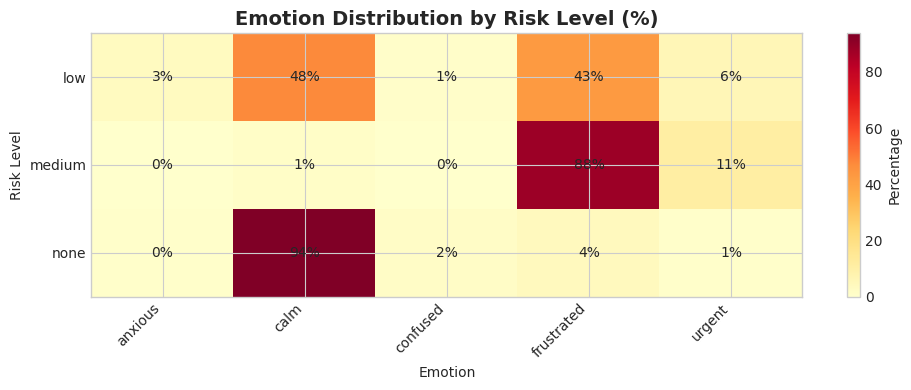

In [208]:
"""
Risk level by emotion.
"""
risk_by_emotion = pd.crosstab(df['risk_level'], df['emotion'], normalize='index') * 100

fig, ax = plt.subplots(figsize=(10, 4))
im = ax.imshow(risk_by_emotion.values, cmap='YlOrRd', aspect='auto')

ax.set_xticks(range(len(risk_by_emotion.columns)))
ax.set_yticks(range(len(risk_by_emotion.index)))
ax.set_xticklabels(risk_by_emotion.columns, rotation=45, ha='right')
ax.set_yticklabels(risk_by_emotion.index)

for i in range(len(risk_by_emotion.index)):
    for j in range(len(risk_by_emotion.columns)):
        val = risk_by_emotion.iloc[i, j]
        ax.text(j, i, f'{val:.0f}%', ha='center', va='center', fontsize=10)

ax.set_xlabel('Emotion')
ax.set_ylabel('Risk Level')
ax.set_title('Emotion Distribution by Risk Level (%)', fontsize=14, fontweight='bold')
plt.colorbar(im, label='Percentage')
plt.tight_layout()
plt.show()

In [209]:
"""
Escalation required distribution.
"""
esc_counts = df['escalation_required'].value_counts()
esc_pcts = df['escalation_required'].value_counts(normalize=True) * 100

print("Escalation Required Distribution:")
pd.DataFrame({'Count': esc_counts, 'Percentage': esc_pcts.round(1)})

Escalation Required Distribution:


,Count,Percentage
escalation_required,,
False,846,84.6
True,154,15.4


In [210]:
"""
Escalation rate by topic.
"""
esc_by_topic = df.groupby('topic')['escalation_required'].agg(['sum', 'count'])
esc_by_topic['rate'] = (esc_by_topic['sum'] / esc_by_topic['count'] * 100).round(1)
esc_by_topic = esc_by_topic.sort_values('rate', ascending=False)
esc_by_topic.columns = ['Escalations', 'Total', 'Rate (%)']

print("Escalation Rate by Topic:")
esc_by_topic

Escalation Rate by Topic:


,Escalations,Total,Rate (%)
topic,,,
"Complaints, Escalations & Negative Feedback",3,3,100.0
"Orders, Shipping & Delivery",48,218,22.0
"Billing, Charges & Price Discrepancies",11,60,18.3
"Returns, Refunds & Exchanges",53,312,17.0
Product Defects & Fulfillment Errors,8,59,13.6
"Promotions, Discounts & Loyalty",6,46,13.0
Technical & Platform Issues,3,24,12.5
Account Access & Customer Profile,16,144,11.1
Product Information & Availability,6,125,4.8


In [211]:
"""
Escalation rate by emotion.
"""
esc_by_emotion = df.groupby('emotion')['escalation_required'].agg(['sum', 'count'])
esc_by_emotion['rate'] = (esc_by_emotion['sum'] / esc_by_emotion['count'] * 100).round(1)
esc_by_emotion = esc_by_emotion.sort_values('rate', ascending=False)
esc_by_emotion.columns = ['Escalations', 'Total', 'Rate (%)']

print("Escalation Rate by Emotion:")
esc_by_emotion

Escalation Rate by Emotion:


,Escalations,Total,Rate (%)
emotion,,,
urgent,15,40,37.5
frustrated,114,305,37.4
anxious,3,12,25.0
confused,2,11,18.2
calm,20,632,3.2


Escalation Flags Distribution (conversations with any flag: 27):


,Count,Percentage
severe_dissatisfaction,27,2.7


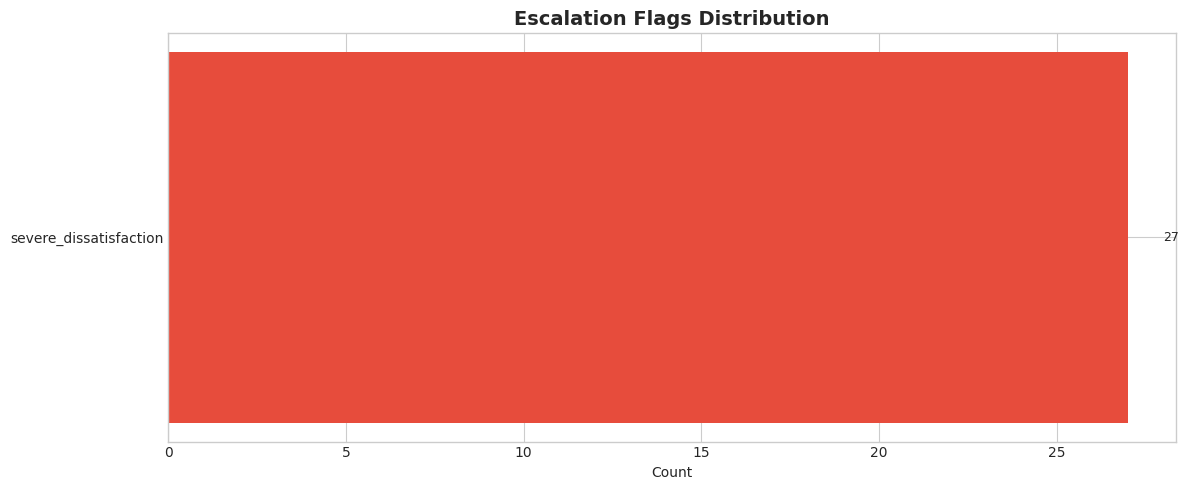

In [212]:
"""
Escalation flags distribution.
"""
all_flags = [f for flags in df['escalation_flags'] for f in flags]
flag_counts = Counter(all_flags)

if flag_counts:
    flag_df = pd.DataFrame.from_dict(flag_counts, orient='index', columns=['Count'])
    flag_df = flag_df.sort_values('Count', ascending=False)
    flag_df['Percentage'] = (flag_df['Count'] / len(df) * 100).round(1)
    
    print(f"Escalation Flags Distribution (conversations with any flag: {sum(len(f) > 0 for f in df['escalation_flags'])}):")
    display(flag_df)
    
    # Bar chart
    fig, ax = plt.subplots(figsize=(12, 5))
    bars = ax.barh(flag_df.index, flag_df['Count'].values, color='#e74c3c')
    
    for bar, count in zip(bars, flag_df['Count'].values):
        ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                str(count), va='center', fontsize=9)
    
    ax.set_xlabel('Count')
    ax.set_title('Escalation Flags Distribution', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No escalation flags found in the dataset.")

In [213]:
"""
Escalation flags co-occurrence analysis.
"""
multi_flag_convos = df[df['escalation_flags'].apply(len) > 1]

if len(multi_flag_convos) > 0:
    flag_pairs = []
    for flags in multi_flag_convos['escalation_flags']:
        flag_pairs.extend(combinations(sorted(flags), 2))
    
    if flag_pairs:
        pair_counts = Counter(flag_pairs)
        print(f"Conversations with multiple flags: {len(multi_flag_convos)}")
        print("\nMost common flag combinations:")
        for pair, count in pair_counts.most_common(10):
            print(f"  {pair[0]} + {pair[1]}: {count}")
    else:
        print("No flag combinations found.")
else:
    print("No conversations with multiple escalation flags.")

No conversations with multiple escalation flags.


---
## 8. Operational Actions Analysis

Analyzing recommended operational actions across conversations.

In [214]:
"""
Operational actions distribution.
"""
all_actions = [a for actions in df['operational_actions'] for a in actions]
action_counts = Counter(all_actions)

action_df = pd.DataFrame.from_dict(action_counts, orient='index', columns=['Count'])
action_df = action_df.sort_values('Count', ascending=False)
action_df['Percentage'] = (action_df['Count'] / len(df) * 100).round(1)

print(f"Total unique actions: {len(action_counts)}")
print(f"Total action occurrences: {len(all_actions)}")
print(f"Avg actions per conversation: {len(all_actions)/len(df):.2f}")
print(f"\nOperational Actions Distribution:")
action_df

Total unique actions: 18
Total action occurrences: 957
Avg actions per conversation: 0.96

Operational Actions Distribution:


,Count,Percentage
initiate_return,201,20.1
check_order_status,139,13.9
initiate_refund,134,13.4
initiate_exchange_replacement,115,11.5
escalate_to_tier2_support,46,4.6
provide_tracking_link_or_update,41,4.1
update_customer_details,41,4.1
resend_otp_or_verification,39,3.9
reset_password_or_otp,39,3.9
initiate_warranty_claim,36,3.6


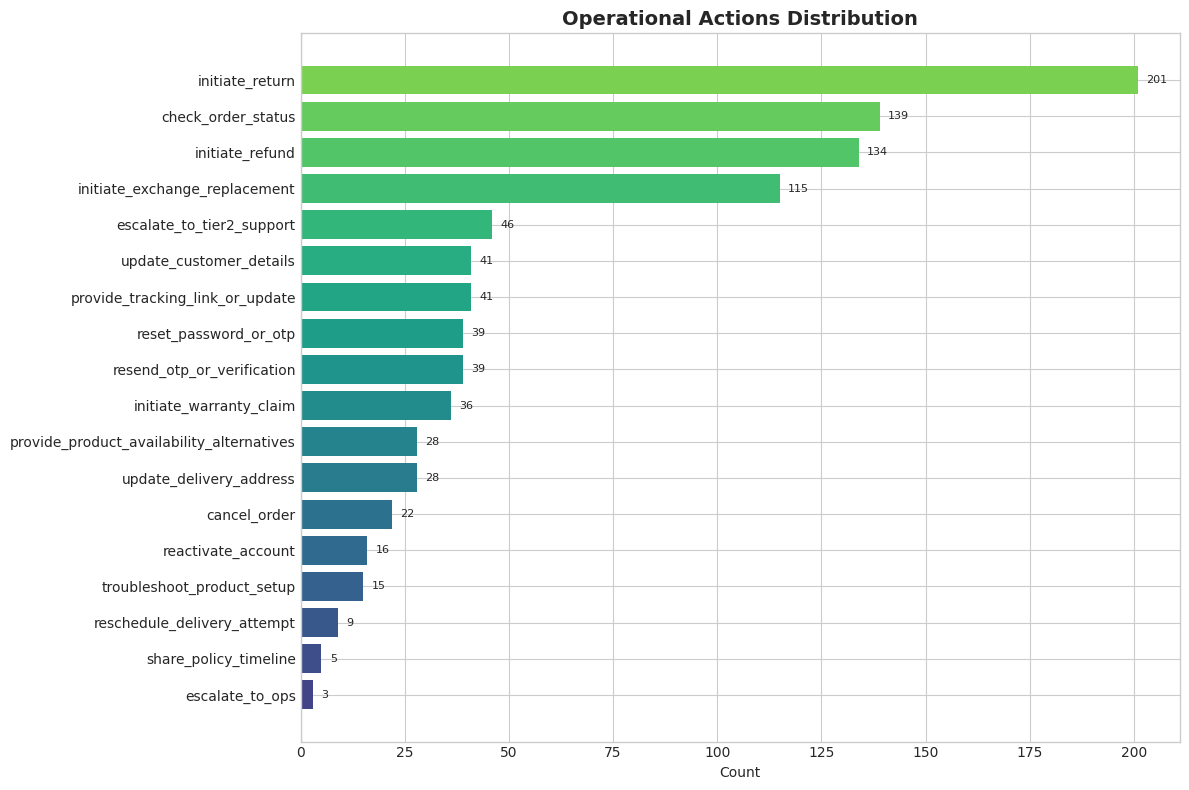

In [215]:
"""
Operational actions bar chart.
"""
fig, ax = plt.subplots(figsize=(12, 8))

action_sorted = action_df.sort_values('Count', ascending=True)
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(action_sorted)))

bars = ax.barh(action_sorted.index, action_sorted['Count'].values, color=colors)

for bar, count in zip(bars, action_sorted['Count'].values):
    ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, 
            str(count), va='center', fontsize=8)

ax.set_xlabel('Count')
ax.set_title('Operational Actions Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

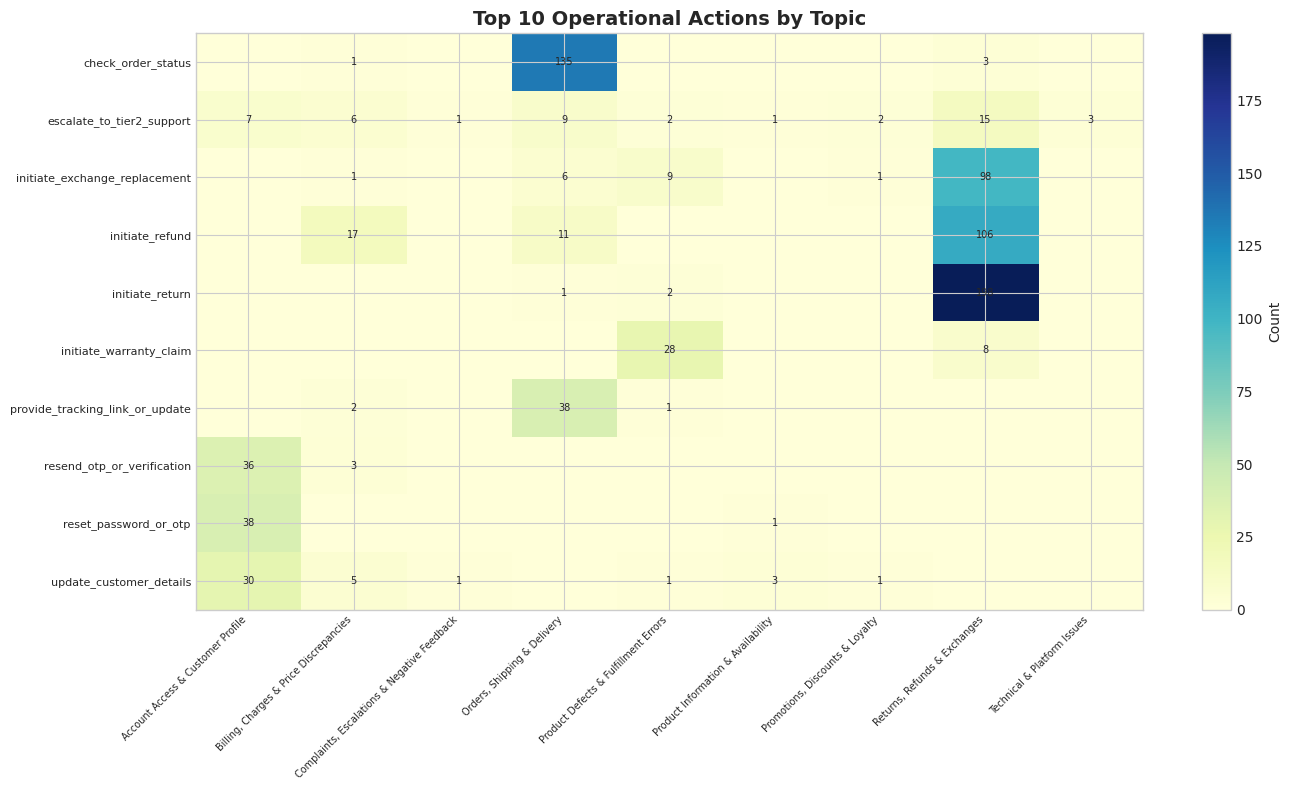

In [216]:
"""
Top actions by topic.
"""
action_topic_data = []
for _, row in df.iterrows():
    for action in row['operational_actions']:
        action_topic_data.append({'topic': row['topic'], 'action': action})

action_topic_df = pd.DataFrame(action_topic_data)

if len(action_topic_df) > 0:
    action_by_topic = pd.crosstab(action_topic_df['action'], action_topic_df['topic'])
    
    # Show top 10 actions
    top_actions = action_df.head(10).index.tolist()
    action_by_topic_top = action_by_topic.loc[action_by_topic.index.isin(top_actions)]
    
    fig, ax = plt.subplots(figsize=(14, 8))
    im = ax.imshow(action_by_topic_top.values, cmap='YlGnBu', aspect='auto')
    
    ax.set_xticks(range(len(action_by_topic_top.columns)))
    ax.set_yticks(range(len(action_by_topic_top.index)))
    ax.set_xticklabels(action_by_topic_top.columns, rotation=45, ha='right', fontsize=7)
    ax.set_yticklabels(action_by_topic_top.index, fontsize=8)
    
    for i in range(len(action_by_topic_top.index)):
        for j in range(len(action_by_topic_top.columns)):
            val = action_by_topic_top.iloc[i, j]
            if val > 0:
                ax.text(j, i, str(val), ha='center', va='center', fontsize=7)
    
    ax.set_title('Top 10 Operational Actions by Topic', fontsize=14, fontweight='bold')
    plt.colorbar(im, label='Count')
    plt.tight_layout()
    plt.show()

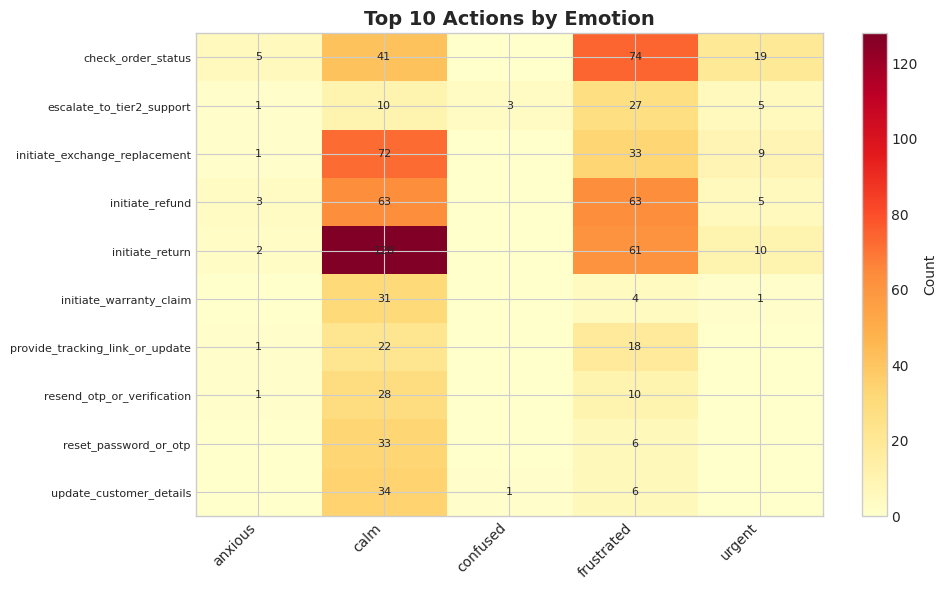

In [217]:
"""
Actions by emotion.
"""
action_emotion_data = []
for _, row in df.iterrows():
    for action in row['operational_actions']:
        action_emotion_data.append({'emotion': row['emotion'], 'action': action})

action_emotion_df = pd.DataFrame(action_emotion_data)

if len(action_emotion_df) > 0:
    action_by_emotion = pd.crosstab(action_emotion_df['action'], action_emotion_df['emotion'])
    
    top_actions = action_df.head(10).index.tolist()
    action_by_emotion_top = action_by_emotion.loc[action_by_emotion.index.isin(top_actions)]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(action_by_emotion_top.values, cmap='YlOrRd', aspect='auto')
    
    ax.set_xticks(range(len(action_by_emotion_top.columns)))
    ax.set_yticks(range(len(action_by_emotion_top.index)))
    ax.set_xticklabels(action_by_emotion_top.columns, rotation=45, ha='right')
    ax.set_yticklabels(action_by_emotion_top.index, fontsize=8)
    
    for i in range(len(action_by_emotion_top.index)):
        for j in range(len(action_by_emotion_top.columns)):
            val = action_by_emotion_top.iloc[i, j]
            if val > 0:
                ax.text(j, i, str(val), ha='center', va='center', fontsize=8)
    
    ax.set_title('Top 10 Actions by Emotion', fontsize=14, fontweight='bold')
    plt.colorbar(im, label='Count')
    plt.tight_layout()
    plt.show()

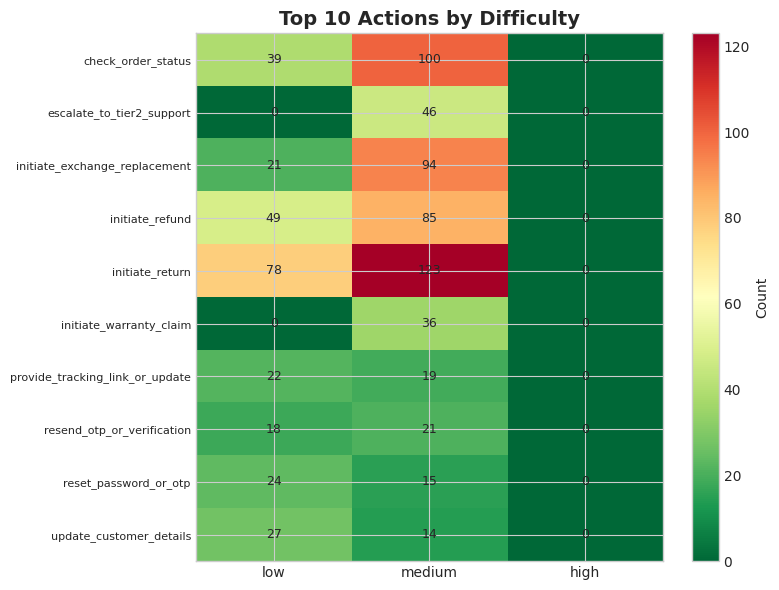

In [218]:
"""
Actions by difficulty level.
"""
action_diff_data = []
for _, row in df.iterrows():
    for action in row['operational_actions']:
        action_diff_data.append({'difficulty': row['difficulty'], 'action': action})

action_diff_df = pd.DataFrame(action_diff_data)

if len(action_diff_df) > 0:
    action_by_diff = pd.crosstab(action_diff_df['action'], action_diff_df['difficulty'])
    
    # Ensure column order
    for col in ['low', 'medium', 'high']:
        if col not in action_by_diff.columns:
            action_by_diff[col] = 0
    action_by_diff = action_by_diff[['low', 'medium', 'high']]
    
    top_actions = action_df.head(10).index.tolist()
    action_by_diff_top = action_by_diff.loc[action_by_diff.index.isin(top_actions)]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(action_by_diff_top.values, cmap='RdYlGn_r', aspect='auto')
    
    ax.set_xticks(range(len(action_by_diff_top.columns)))
    ax.set_yticks(range(len(action_by_diff_top.index)))
    ax.set_xticklabels(action_by_diff_top.columns)
    ax.set_yticklabels(action_by_diff_top.index, fontsize=8)
    
    for i in range(len(action_by_diff_top.index)):
        for j in range(len(action_by_diff_top.columns)):
            val = action_by_diff_top.iloc[i, j]
            ax.text(j, i, str(val), ha='center', va='center', fontsize=9)
    
    ax.set_title('Top 10 Actions by Difficulty', fontsize=14, fontweight='bold')
    plt.colorbar(im, label='Count')
    plt.tight_layout()
    plt.show()

In [219]:
"""
Action co-occurrence analysis.
"""
multi_action_convos = df[df['operational_actions'].apply(len) > 1]

print(f"Conversations with multiple actions: {len(multi_action_convos)} ({len(multi_action_convos)/len(df)*100:.1f}%)")

if len(multi_action_convos) > 0:
    action_pairs = []
    for actions in multi_action_convos['operational_actions']:
        action_pairs.extend(combinations(sorted(actions), 2))
    
    if action_pairs:
        pair_counts = Counter(action_pairs)
        print("\nMost common action combinations:")
        for pair, count in pair_counts.most_common(15):
            print(f"  {pair[0]} + {pair[1]}: {count}")

Conversations with multiple actions: 210 (21.0%)

Most common action combinations:
  initiate_refund + initiate_return: 71
  initiate_exchange_replacement + initiate_return: 68
  check_order_status + provide_tracking_link_or_update: 21
  cancel_order + initiate_refund: 7
  escalate_to_tier2_support + initiate_return: 7
  check_order_status + initiate_refund: 6
  check_order_status + escalate_to_tier2_support: 5
  escalate_to_tier2_support + initiate_exchange_replacement: 5
  provide_tracking_link_or_update + update_delivery_address: 4
  check_order_status + update_delivery_address: 4
  check_order_status + initiate_exchange_replacement: 4
  resend_otp_or_verification + reset_password_or_otp: 3
  reset_password_or_otp + update_customer_details: 3
  check_order_status + escalate_to_ops: 3
  initiate_exchange_replacement + initiate_refund: 3


---
## 9. Root Cause Analysis

Analyzing root cause codes across conversations.

In [220]:
"""
Root cause code distribution.
"""
rc_counts = df['root_cause_code'].value_counts()
rc_pcts = df['root_cause_code'].value_counts(normalize=True) * 100

rc_df = pd.DataFrame({
    'Count': rc_counts,
    'Percentage': rc_pcts.round(1)
})

print(f"Total unique root cause codes: {len(rc_counts)}")
print(f"\nRoot Cause Code Distribution:")
rc_df

Total unique root cause codes: 16

Root Cause Code Distribution:


,Count,Percentage
root_cause_code,,
unknown_or_multi_intent,543,54.3
product_defective_or_doa,165,16.5
delivery_attempt_failed,73,7.3
out_of_stock,40,4.0
refund_timeline_cod,36,3.6
otp_attempts_exceeded_or_lockout,20,2.0
missing_parts_or_wrong_item,19,1.9
otp_not_received,18,1.8
delivery_address_issue,17,1.7


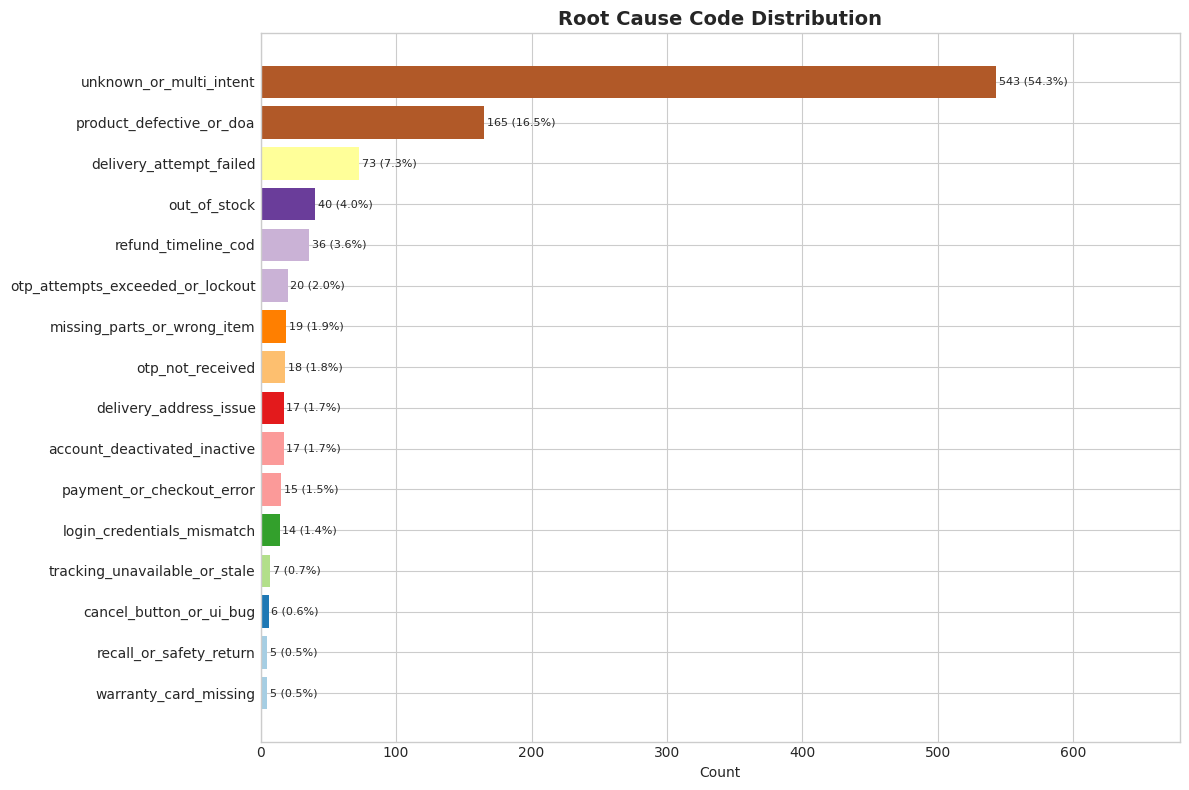

In [221]:
"""
Root cause code bar chart.
"""
fig, ax = plt.subplots(figsize=(12, 8))

rc_sorted = rc_counts.sort_values(ascending=True)
colors = plt.cm.Paired(np.linspace(0, 1, len(rc_sorted)))

bars = ax.barh(rc_sorted.index, rc_sorted.values, color=colors)

for bar, count in zip(bars, rc_sorted.values):
    ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, 
            f'{count} ({count/len(df)*100:.1f}%)', va='center', fontsize=8)

ax.set_xlabel('Count')
ax.set_title('Root Cause Code Distribution', fontsize=14, fontweight='bold')
ax.set_xlim(0, max(rc_sorted.values) * 1.25)
plt.tight_layout()
plt.show()

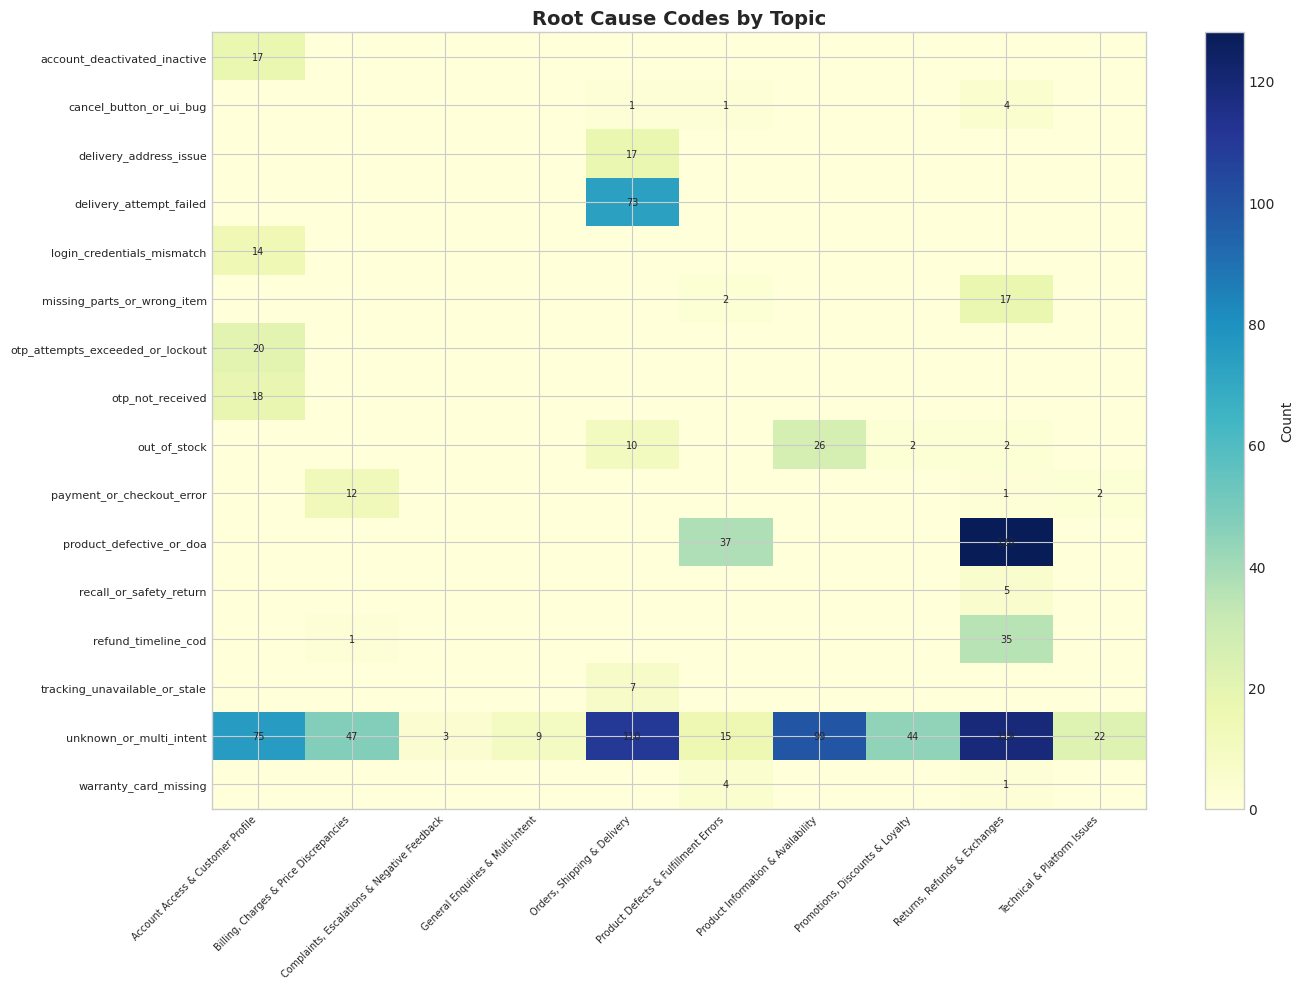

In [222]:
"""
Root cause by topic heatmap.
"""
rc_by_topic = pd.crosstab(df['root_cause_code'], df['topic'])

fig, ax = plt.subplots(figsize=(14, 10))
im = ax.imshow(rc_by_topic.values, cmap='YlGnBu', aspect='auto')

ax.set_xticks(range(len(rc_by_topic.columns)))
ax.set_yticks(range(len(rc_by_topic.index)))
ax.set_xticklabels(rc_by_topic.columns, rotation=45, ha='right', fontsize=7)
ax.set_yticklabels(rc_by_topic.index, fontsize=8)

for i in range(len(rc_by_topic.index)):
    for j in range(len(rc_by_topic.columns)):
        val = rc_by_topic.iloc[i, j]
        if val > 0:
            ax.text(j, i, str(val), ha='center', va='center', fontsize=7)

ax.set_title('Root Cause Codes by Topic', fontsize=14, fontweight='bold')
plt.colorbar(im, label='Count')
plt.tight_layout()
plt.show()

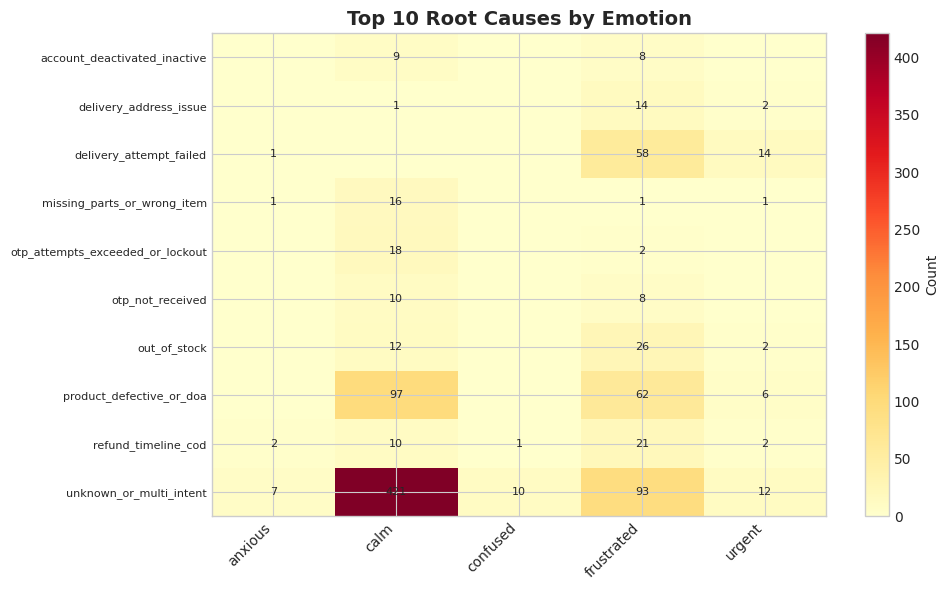

In [223]:
"""
Root cause by emotion.
"""
rc_by_emotion = pd.crosstab(df['root_cause_code'], df['emotion'])

# Show top 10 root causes
top_rc = rc_counts.head(10).index.tolist()
rc_by_emotion_top = rc_by_emotion.loc[rc_by_emotion.index.isin(top_rc)]

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(rc_by_emotion_top.values, cmap='YlOrRd', aspect='auto')

ax.set_xticks(range(len(rc_by_emotion_top.columns)))
ax.set_yticks(range(len(rc_by_emotion_top.index)))
ax.set_xticklabels(rc_by_emotion_top.columns, rotation=45, ha='right')
ax.set_yticklabels(rc_by_emotion_top.index, fontsize=8)

for i in range(len(rc_by_emotion_top.index)):
    for j in range(len(rc_by_emotion_top.columns)):
        val = rc_by_emotion_top.iloc[i, j]
        if val > 0:
            ax.text(j, i, str(val), ha='center', va='center', fontsize=8)

ax.set_title('Top 10 Root Causes by Emotion', fontsize=14, fontweight='bold')
plt.colorbar(im, label='Count')
plt.tight_layout()
plt.show()

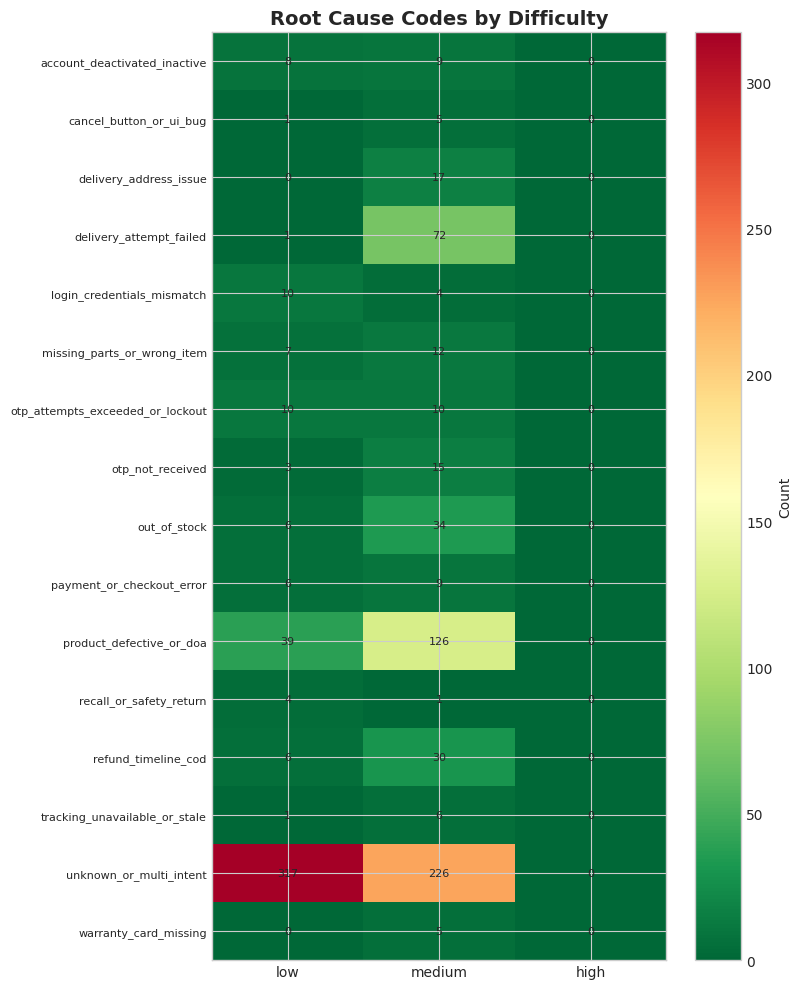

In [224]:
"""
Root cause by difficulty.
"""
rc_by_diff = pd.crosstab(df['root_cause_code'], df['difficulty'])

for col in ['low', 'medium', 'high']:
    if col not in rc_by_diff.columns:
        rc_by_diff[col] = 0
rc_by_diff = rc_by_diff[['low', 'medium', 'high']]

fig, ax = plt.subplots(figsize=(8, 10))
im = ax.imshow(rc_by_diff.values, cmap='RdYlGn_r', aspect='auto')

ax.set_xticks(range(len(rc_by_diff.columns)))
ax.set_yticks(range(len(rc_by_diff.index)))
ax.set_xticklabels(rc_by_diff.columns)
ax.set_yticklabels(rc_by_diff.index, fontsize=8)

for i in range(len(rc_by_diff.index)):
    for j in range(len(rc_by_diff.columns)):
        val = rc_by_diff.iloc[i, j]
        ax.text(j, i, str(val), ha='center', va='center', fontsize=8)

ax.set_title('Root Cause Codes by Difficulty', fontsize=14, fontweight='bold')
plt.colorbar(im, label='Count')
plt.tight_layout()
plt.show()

---
## 10. Cross-Field Correlations

Analyzing relationships between multiple categorical fields to identify patterns.

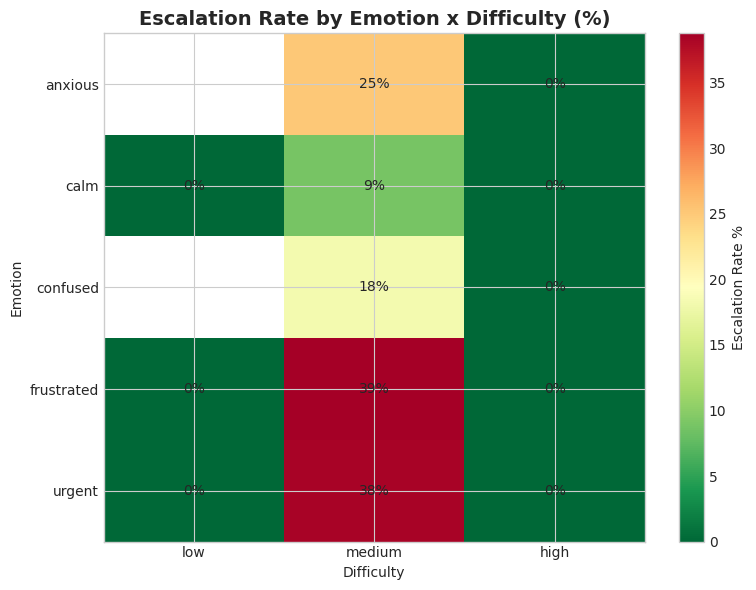


Escalation Rate by Emotion x Difficulty:


difficulty,low,medium,high
emotion,,,
anxious,NaN,25.0,0
calm,0.0,8.9,0
confused,NaN,18.2,0
frustrated,0.0,38.8,0
urgent,0.0,38.5,0


In [225]:
"""
Emotion x Difficulty -> Escalation Rate heatmap.
Shows how the combination of emotion and difficulty affects escalation probability.
"""
# Create pivot table: escalation rate by emotion and difficulty
emotion_diff_esc = df.pivot_table(
    index='emotion', 
    columns='difficulty', 
    values='escalation_required', 
    aggfunc='mean'
) * 100

# Reorder columns
for col in ['low', 'medium', 'high']:
    if col not in emotion_diff_esc.columns:
        emotion_diff_esc[col] = 0
emotion_diff_esc = emotion_diff_esc[['low', 'medium', 'high']]

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(emotion_diff_esc.values, cmap='RdYlGn_r', aspect='auto', vmin=0)

ax.set_xticks(range(len(emotion_diff_esc.columns)))
ax.set_yticks(range(len(emotion_diff_esc.index)))
ax.set_xticklabels(emotion_diff_esc.columns)
ax.set_yticklabels(emotion_diff_esc.index)

for i in range(len(emotion_diff_esc.index)):
    for j in range(len(emotion_diff_esc.columns)):
        val = emotion_diff_esc.iloc[i, j]
        if not pd.isna(val):
            ax.text(j, i, f'{val:.0f}%', ha='center', va='center', fontsize=10)

ax.set_xlabel('Difficulty')
ax.set_ylabel('Emotion')
ax.set_title('Escalation Rate by Emotion x Difficulty (%)', fontsize=14, fontweight='bold')
plt.colorbar(im, label='Escalation Rate %')
plt.tight_layout()
plt.show()

print("\nEscalation Rate by Emotion x Difficulty:")
emotion_diff_esc.round(1)

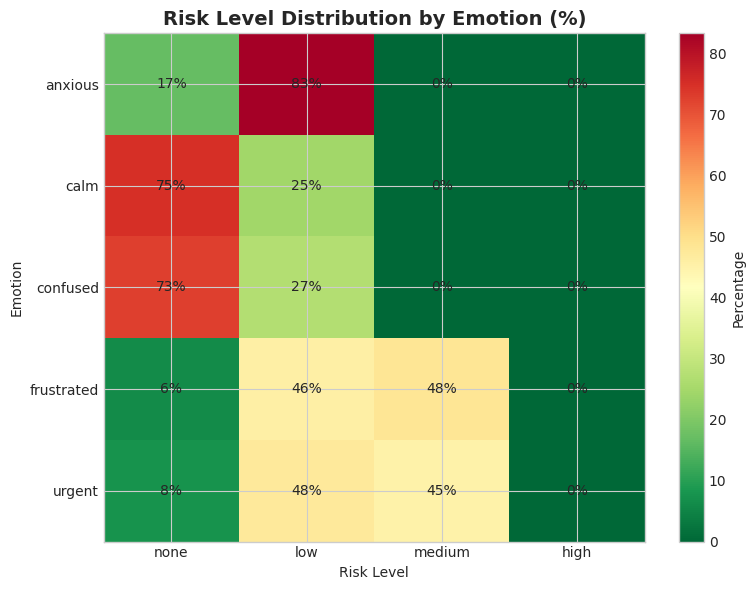

In [226]:
"""
Emotion x Risk Level distribution.
"""
emotion_risk = pd.crosstab(df['emotion'], df['risk_level'], normalize='index') * 100

for col in ['none', 'low', 'medium', 'high']:
    if col not in emotion_risk.columns:
        emotion_risk[col] = 0
emotion_risk = emotion_risk[['none', 'low', 'medium', 'high']]

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(emotion_risk.values, cmap='RdYlGn_r', aspect='auto')

ax.set_xticks(range(len(emotion_risk.columns)))
ax.set_yticks(range(len(emotion_risk.index)))
ax.set_xticklabels(emotion_risk.columns)
ax.set_yticklabels(emotion_risk.index)

for i in range(len(emotion_risk.index)):
    for j in range(len(emotion_risk.columns)):
        val = emotion_risk.iloc[i, j]
        ax.text(j, i, f'{val:.0f}%', ha='center', va='center', fontsize=10)

ax.set_xlabel('Risk Level')
ax.set_ylabel('Emotion')
ax.set_title('Risk Level Distribution by Emotion (%)', fontsize=14, fontweight='bold')
plt.colorbar(im, label='Percentage')
plt.tight_layout()
plt.show()

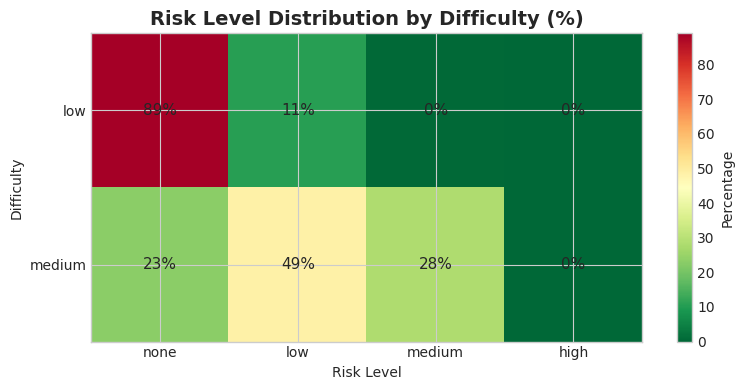

In [227]:
"""
Difficulty x Risk Level distribution.
"""
diff_risk = pd.crosstab(df['difficulty'], df['risk_level'], normalize='index') * 100

for col in ['none', 'low', 'medium', 'high']:
    if col not in diff_risk.columns:
        diff_risk[col] = 0
diff_risk = diff_risk[['none', 'low', 'medium', 'high']]

# Reorder index
diff_order = ['low', 'medium', 'high']
diff_risk = diff_risk.reindex([d for d in diff_order if d in diff_risk.index])

fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(diff_risk.values, cmap='RdYlGn_r', aspect='auto')

ax.set_xticks(range(len(diff_risk.columns)))
ax.set_yticks(range(len(diff_risk.index)))
ax.set_xticklabels(diff_risk.columns)
ax.set_yticklabels(diff_risk.index)

for i in range(len(diff_risk.index)):
    for j in range(len(diff_risk.columns)):
        val = diff_risk.iloc[i, j]
        ax.text(j, i, f'{val:.0f}%', ha='center', va='center', fontsize=11)

ax.set_xlabel('Risk Level')
ax.set_ylabel('Difficulty')
ax.set_title('Risk Level Distribution by Difficulty (%)', fontsize=14, fontweight='bold')
plt.colorbar(im, label='Percentage')
plt.tight_layout()
plt.show()